In [35]:
import pandas as pd
import numpy as np
import math
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [36]:
df = pd.read_json('./programmers_salary_final_balanced.json')

In [37]:
df['skills_str'] = df['skills'].apply(lambda x: ' '.join(x))
df['education_str'] = df['education'].fillna("").astype(str).str.lower()

In [38]:
tfidf_skills = TfidfVectorizer(max_features=200)
X_skills = tfidf_skills.fit_transform(df['skills_str']).toarray()

tfidf_edu = TfidfVectorizer(max_features=100)
X_edu = tfidf_edu.fit_transform(df['education_str']).toarray()

In [39]:
role_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_role = role_encoder.fit_transform(df[['role']])

work_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_work = work_encoder.fit_transform(df[['work_type']])


In [40]:
X_exp = df[['estimated_experience_years']].values

X_all = np.concatenate([X_exp, X_skills, X_edu, X_role, X_work], axis=1)
y = df['salary'].values

In [41]:
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

In [43]:
xgb = XGBRegressor(random_state=42)

In [ ]:
param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [45]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [200, 400, 600],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=2)

In [46]:
model = grid.best_estimator_

In [47]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid.best_params_}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}
MAE: 5672.21
R² Score: 0.86


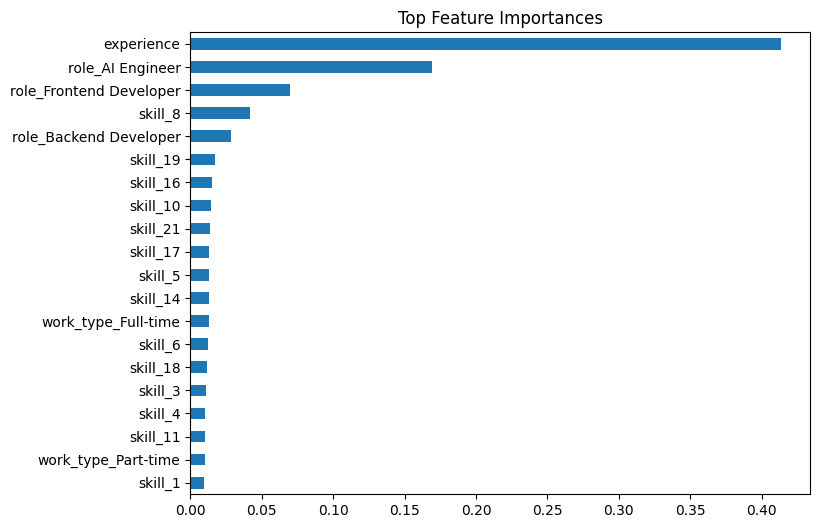

In [48]:
importances = model.feature_importances_

features = (
    ['experience'] +
    [f'skill_{i}' for i in range(X_skills.shape[1])] +
    [f'edu_{i}' for i in range(X_edu.shape[1])] +
    list(role_encoder.get_feature_names_out(['role'])) +
    list(work_encoder.get_feature_names_out(['work_type']))
)

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp.head(20).plot(kind='barh', figsize=(8,6))
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [49]:
joblib.dump(tfidf_skills, "tfidf_skills.pkl")
joblib.dump(tfidf_edu, "tfidf_edu.pkl")
joblib.dump(role_encoder, "role_encoder.pkl")
joblib.dump(work_encoder, "work_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(model, "xgboost_model.pkl")

print("✅ Model and Encoders Saved Successfully!")

✅ Model and Encoders Saved Successfully!


In [58]:
import joblib
import numpy as np
import math


tfidf_skills = joblib.load("tfidf_skills.pkl")
tfidf_edu = joblib.load("tfidf_edu.pkl")
role_encoder = joblib.load("role_encoder.pkl")
work_encoder = joblib.load("work_encoder.pkl")
scaler = joblib.load("scaler.pkl")
model = joblib.load("xgboost_model.pkl")


new_employee = {
    "estimated_experience_years": 1,
    "skills_str": "Artificial Intelligence and NLP specialization - Hands-on experience in machine learning, deep learning, and working with Large Language Models (LLMs) - Extensive experience in backend development using Node.js",
    "education_str": "Bachelor's degree in Information Engineering at Al-Sham Private University",
    "role": "AI",
    "work_type": "Remote"
}

skills_vec = tfidf_skills.transform([new_employee["skills_str"]]).toarray()
edu_vec = tfidf_edu.transform([new_employee["education_str"].lower()]).toarray()
role_vec = role_encoder.transform([[new_employee["role"]]])
work_vec = work_encoder.transform([[new_employee["work_type"]]])
exp_vec = np.array([[new_employee["estimated_experience_years"]]])

final_vec = np.concatenate([exp_vec, skills_vec, edu_vec, role_vec, work_vec], axis=1)


final_vec = scaler.transform(final_vec)


salary_pred = model.predict(final_vec)[0]

salary_rounded = int(math.ceil(salary_pred / 100) * 100)


monthly_salary = salary_rounded / 12
monthly_salary_rounded = int(math.ceil(monthly_salary / 100) * 100)

print(f"✅ Predicted Yearly Salary: {salary_rounded} $")
print(f"✅ Predicted Monthly Salary: {monthly_salary_rounded} $")


✅ Predicted Yearly Salary: 45800 $
✅ Predicted Monthly Salary: 3900 $


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
